
## **Step 2 — Dataset Exploration**: Cats vs Dogs 


In [1]:
! pip install tensorflow

In [2]:
! pip install numpy

In [1]:

import os
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [4]:
# Configure paths
from pathlib import Path

BASE_DIR = Path("cats_and_dogs_filtered")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "validation"

for p in [BASE_DIR, TRAIN_DIR, VAL_DIR]:
    print(f"{p}: {'OK' if p.exists() else 'MISSING'}")


cats_and_dogs_filtered: OK
cats_and_dogs_filtered\train: OK
cats_and_dogs_filtered\validation: OK


In [5]:

def count_images_in(dirpath: Path):
    cats_dir = dirpath / "cats"
    dogs_dir = dirpath / "dogs"
    cats = [f for f in cats_dir.glob("*") if f.is_file()]
    dogs = [f for f in dogs_dir.glob("*") if f.is_file()]
    return len(cats), len(dogs)

train_cats, train_dogs = count_images_in(TRAIN_DIR) if TRAIN_DIR.exists() else (0,0)
val_cats, val_dogs     = count_images_in(VAL_DIR)   if VAL_DIR.exists() else (0,0)

print(f"Training cats: {train_cats}")
print(f"Training dogs: {train_dogs}")
print(f"Validation cats: {val_cats}")
print(f"Validation dogs: {val_dogs}")


Training cats: 1000
Training dogs: 1000
Validation cats: 500
Validation dogs: 500


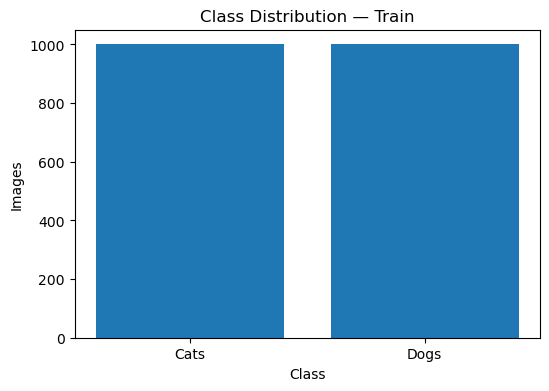

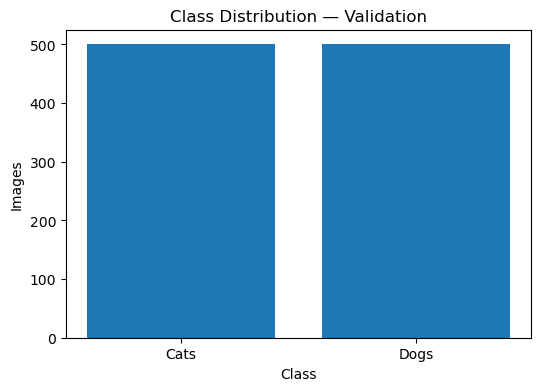

In [6]:

# Bar chart: Train
labels = ["Cats", "Dogs"]
train_counts = [train_cats, train_dogs]
val_counts = [val_cats, val_dogs]

plt.figure(figsize=(6,4))
plt.bar(labels, train_counts)
plt.title("Class Distribution — Train")
plt.xlabel("Class")
plt.ylabel("Images")
plt.show()

# Bar chart: Validation
plt.figure(figsize=(6,4))
plt.bar(labels, val_counts)
plt.title("Class Distribution — Validation")
plt.xlabel("Class")
plt.ylabel("Images")
plt.show()


## Load & Split (80/20 from `train`)

In [ ]:

IMG_SIZE = (150, 150)  
BATCH_SIZE = 32

# Rescale normalizes pixels to [0,1]
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_datagen   = ImageDataGenerator(rescale=1./255)

# 'training' subset = 80% of TRAIN_DIR
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=42
)

# 'validation' subset here acts as our internal test (20% of TRAIN_DIR)
test_generator = train_datagen.flow_from_directory(
    TRAIN_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# External validation (provided in the dataset)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR.as_posix(),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Analyze: class mapping and input shapes

In [8]:

# Class -> index mapping
print("Class indices:", train_generator.class_indices)

# Input shape from the generator
print("Image shape (generator):", train_generator.image_shape)
print("Batch size:", train_generator.batch_size)

# Sample sizes
print("Samples — train:", train_generator.samples)
print("Samples — internal test:", test_generator.samples)
print("Samples — external validation:", validation_generator.samples)

# Steps per epoch helper
def steps_per_epoch(n_samples, batch_size):
    return int(np.ceil(n_samples / batch_size))

print("Steps/epoch — train:", steps_per_epoch(train_generator.samples, BATCH_SIZE))
print("Steps — internal test:", steps_per_epoch(test_generator.samples, BATCH_SIZE))
print("Steps — external validation:", steps_per_epoch(validation_generator.samples, BATCH_SIZE))


Class indices: {'cats': 0, 'dogs': 1}
Image shape (generator): (150, 150, 3)
Batch size: 32
Samples — train: 1600
Samples — internal test: 400
Samples — external validation: 1000
Steps/epoch — train: 50
Steps — internal test: 13
Steps — external validation: 32


## Visualize: sample images and labels

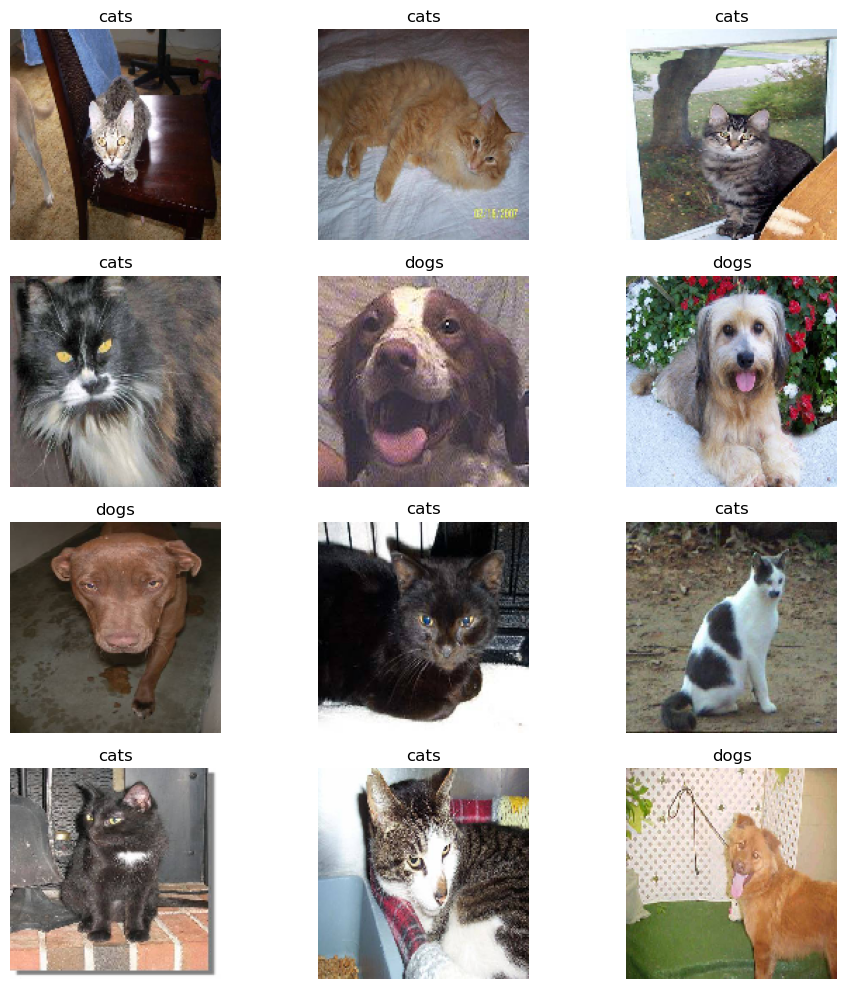

In [9]:

batch_images, batch_labels = next(train_generator)

inv_map = {v:k for k,v in train_generator.class_indices.items()}

plt.figure(figsize=(10,10))
n_show = min(12, len(batch_images))
for i in range(n_show):
    plt.subplot(4,3,i+1)
    plt.imshow(batch_images[i])
    plt.title(inv_map[int(batch_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()



## Normalization: why we use [0,1]

We scale pixel values to the [0,1] range (`rescale=1./255`). This avoids large magnitudes and tends to make optimization more stable. For a small CNN trained from scratch, this default works well in practice.

- Why [0,1]? It’s robust, easy to apply consistently across train/val/test, and it matches Keras’ official examples
- Alternative (more advanced): per‑channel standardization (z‑score) using mean/std computed on the training set. It can help convergence, but you must apply the exact same transform at inference and manage those statistics.
- If you use a pretrained model (ResNet, EfficientNet, etc.), follow that model’s specific preprocessing (often ImageNet‑style normalization). Here, since we train a simple CNN from scratch, [0,1] is perfectly fine.

References:
- Keras image preprocessing and `rescale`: `https://keras.io/api/preprocessing/image/`
- Keras official example (image classification from scratch, rescale=1./255): `https://keras.io/examples/vision/image_classification_from_scratch/`
- Normalization in deep learning : `https://cs231n.github.io/neural-networks-2/#datapre`



In [10]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling

preprocess = Sequential([Rescaling(1./255, input_shape=(*IMG_SIZE, 3))])
preprocess.summary()


c:\Users\loria\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)